In [2]:
#Carrega bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Carrega dataset
insurance = pd.read_csv('insurance.csv')

In [4]:
# Primeiras linhas do dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [100]:
#Verificaremos se tem algum valor nulo entre as variáveis
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Vamos entender o que cada coluna representa e se há necessidade de alguma transformação
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Como vimos não tem nenhum valor nulo e temos 1338 linhas em nossa amostra. Além disso, temos algumas informações sobre as variáveis numéricas. Vamos aprofundar um pouco como age, bmi e children se relacionam com charges, visto que nosso foco é o entendimento destas cobranças.

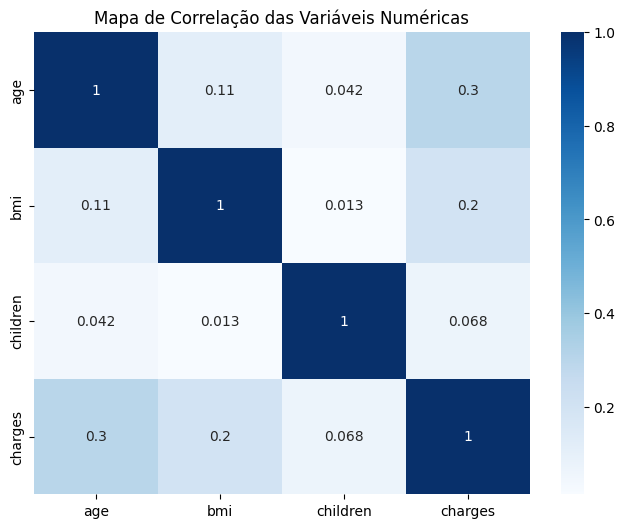

In [7]:
# Análise de correlação entre variáveis numéricas
plt.figure(figsize=(8, 6))
corr = insurance[['age', 'bmi', 'children', 'charges']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Mapa de Correlação das Variáveis Numéricas')
plt.show()

Podemos identificar pela coluna de charges que todas as variáveis numéricas se relacionam positivamente com charges, porém são relações fracas. Mais a frente, teremos que entender como as variáveis categóricas impactam charges.

Text(0.5, 1.0, 'Distribuição do charges com BMI<30')

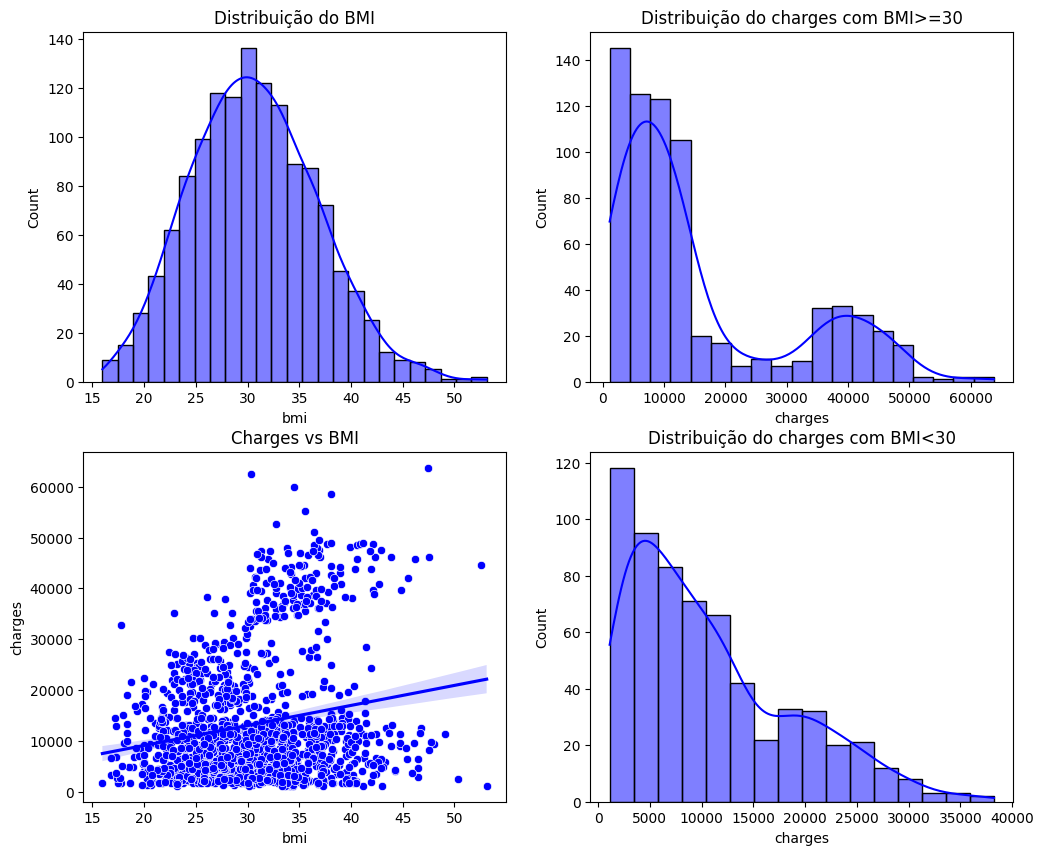

In [8]:
# local e configuracao do plot
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
# Primeiro gráfico é a distribuição do BMI
sns.histplot(insurance['bmi'], ax=ax[0,0], color='b', kde=True)
ax[0,0].set_title('Distribuição do BMI')
# Segundo gráfico é a distribuição da cobrança pelo bmi>=30
sns.histplot(insurance.query("bmi>=30")['charges'], ax=ax[0,1], color='b', kde=True)
ax[0,1].set_title('Distribuição do charges com BMI>=30')
#Terceiro gráfico é a dispersão entre cobrança e bmi
sns.scatterplot(x='bmi', y='charges', data=insurance, ax=ax[1,0], color='b')
sns.regplot(x='bmi', y='charges', data=insurance, ax=ax[1,0], scatter=False, color='b')
ax[1,0].set_title('Charges vs BMI')
# Quarto gráfico é a distribuição da cobrança pelo bmi<30
sns.histplot(insurance.query("bmi<30")['charges'], ax=ax[1,1], color='b', kde=True)
ax[1,1].set_title('Distribuição do charges com BMI<30')

Ao analisar a relação, podemos ver que a distribuição do BMI é normal, tendo seu pico em 30, ao separar antes dos 30 ou 30+ conseguimos identificar que pacientes com BMI de 30 ou mais tem maiores cobranças que a faixa de menor que 30. Relação que é explicada pelo gráfico de disperção, que tem uma relação positiva, mas fraca. Agora vamos comparar as médias e entender a correlação entre as variáveis.

In [9]:
print(insurance.query("bmi<30")['charges'].mean())
print(insurance.query("bmi>=30")['charges'].mean())
print(insurance.query("bmi<30")['charges'].median())
print(insurance.query("bmi>=30")['charges'].median())

10713.666900584787
15552.335468868458
8604.48365
9964.06


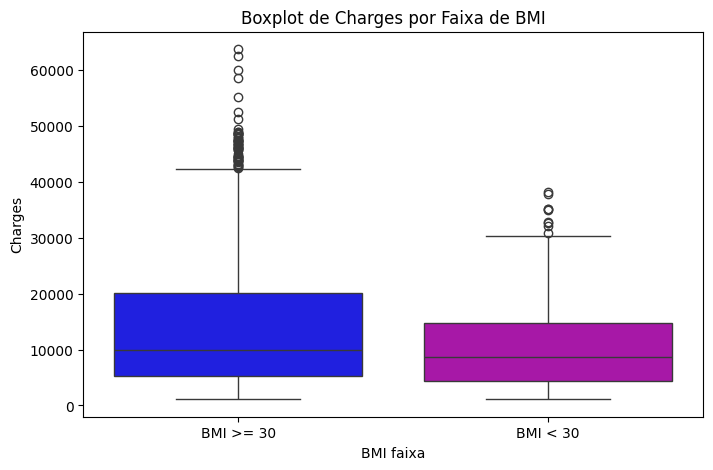

In [10]:

charges_bmi = pd.DataFrame({
    'charges': pd.concat([
        insurance.query("bmi>=30")['charges'],
        insurance.query("bmi<30")['charges']
    ], ignore_index=True),
    'BMI faixa': ['BMI >= 30'] * len(insurance.query("bmi>=30")) + ['BMI < 30'] * len(insurance.query("bmi<30"))
})

plt.figure(figsize=(8, 5))
sns.boxplot(x='BMI faixa', y='charges', data=charges_bmi,hue='BMI faixa' ,palette=['b', 'm'],legend=False)
plt.title('Boxplot de Charges por Faixa de BMI')
plt.ylabel('Charges')
plt.show()

Ao interpretar os dados e aprofundar a análise se confirma que paciente com BMI>=30 tem mais cobranças que pacientes com BMI<30, visto que a mediana do primeiro é maior que a do segundo. Vale ressaltar o uso da mediana, pois ambos são impactados por outliers que estão muito acima da faixa, causando distorção se analisado puramente pela média.

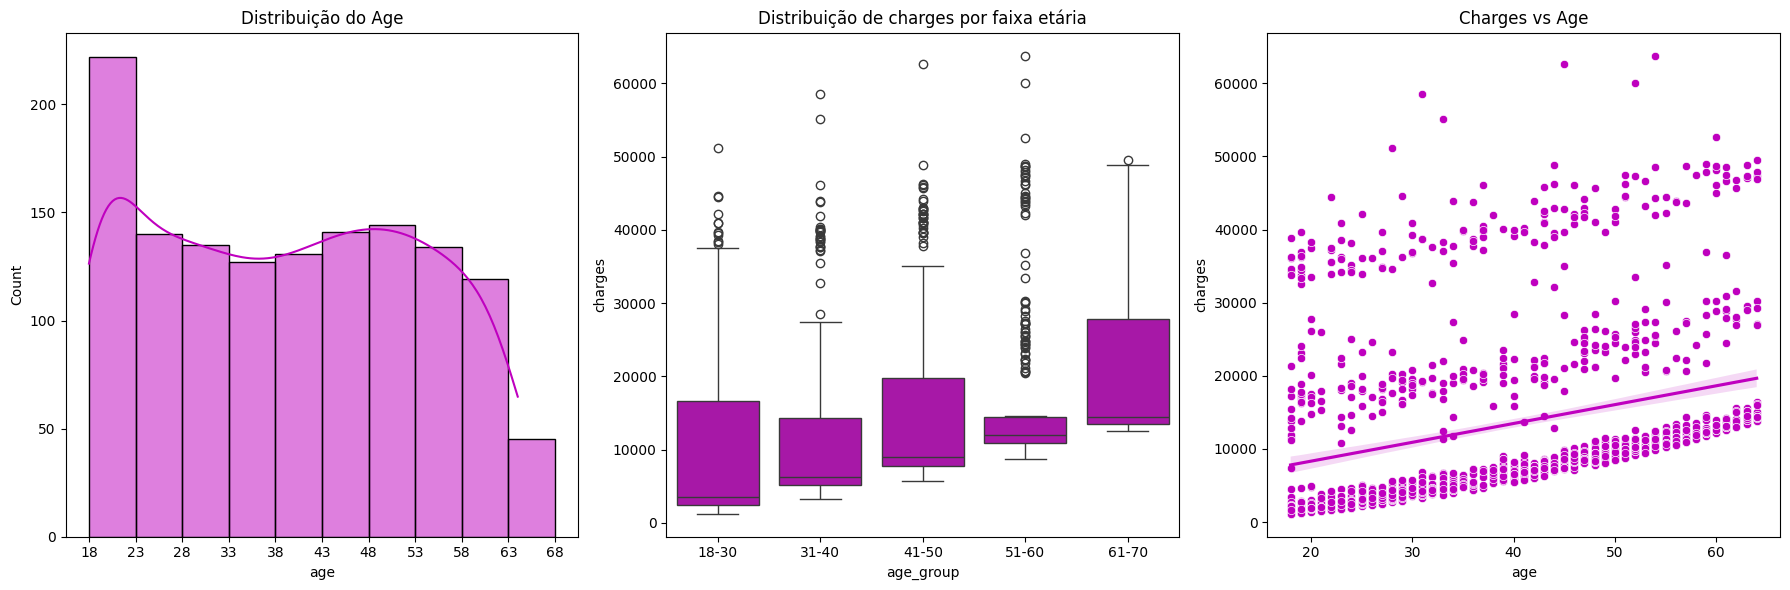

In [12]:
# local e configuracao do plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Primeiro gráfico: distribuição do Age
bins = range(insurance['age'].min(), insurance['age'].max() + 5, 5)
sns.histplot(insurance['age'], ax=ax[0], color='m', kde=True, bins=bins)
ax[0].set_title('Distribuição do Age')
ax[0].set_xticks(list(bins))

# Segundo gráfico: distribuição de charges por faixa etária
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70']
insurance['age_group'] = pd.cut(insurance['age'], bins=bins, labels=labels)
sns.boxplot(data=insurance, x='age_group', y='charges', ax=ax[1], color='m')
ax[1].set_title('Distribuição de charges por faixa etária')

# Terceiro gráfico: dispersão entre age e charges
sns.scatterplot(x='age', y='charges', data=insurance, ax=ax[2], color='m')
sns.regplot(x='age', y='charges', data=insurance, ax=ax[2], scatter=False, color='m')
ax[2].set_title('Charges vs Age')

plt.tight_layout()



In [13]:
insurance.age.corr(insurance.charges)

np.float64(0.29900819333064776)

Pelo gráfico de histograma, identificamos que temos mais jovens do que idosos em nossa amostra, principalmente entre 18 e 23 anos. Porém analisando o segundo gráfico de boxplot e abrindo o gasto pelas faixas de idade entendemos que pessoas com idade mais avançada tem mais despesas, relação a qual é também identificada pela tendencia do gráfico de dispersão e pela correlação positiva de 0.3.

Text(0.5, 1.0, 'Distribuição do charges com BMI<30')

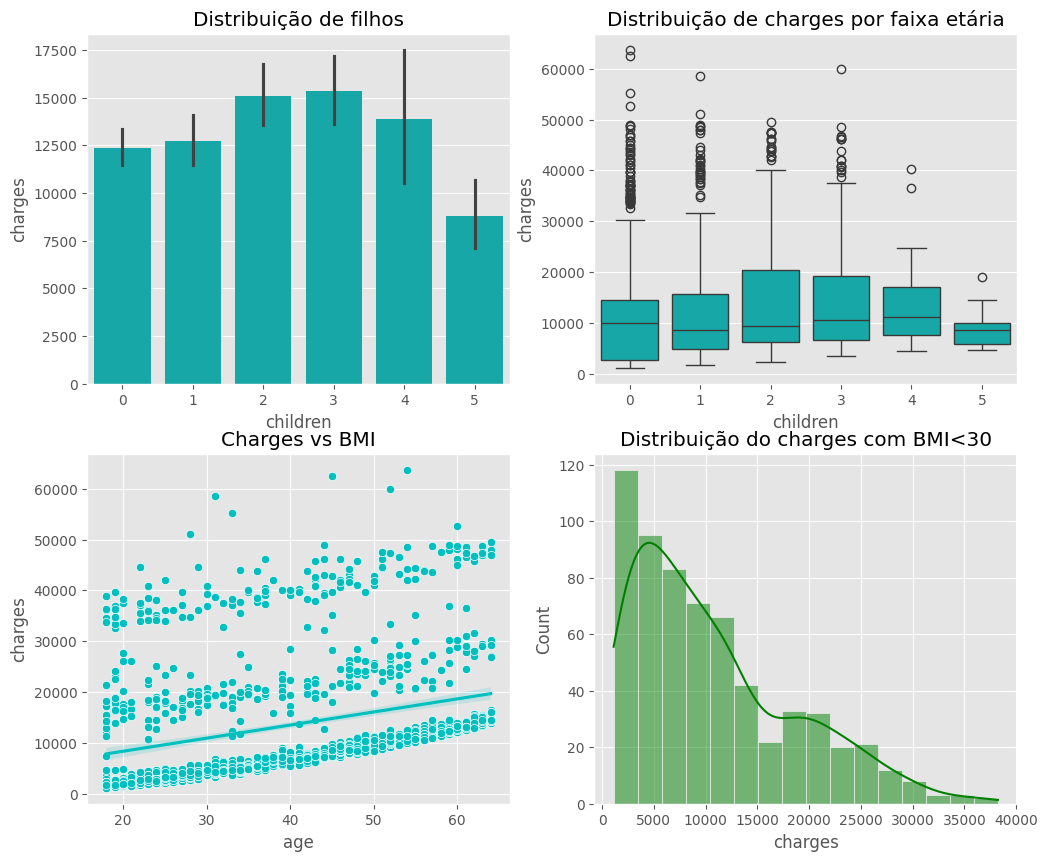

In [119]:
# local e configuracao do plot
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
# Primeiro gráfico é a distribuição do BMI
sns.barplot(data=insurance, x='children', y='charges', ax=ax[0,0], color='c')
ax[0,0].set_title('Distribuição de filhos')
# Segundo gráfico é a distribuição da cobrança pelo bmi>=30
bins = [0, 1, 2, 3, 4, 5]
insurance['age_group'] = pd.cut(insurance['age'], bins=bins,labels=labels)
sns.boxplot(data=insurance, x='children', y='charges', ax=ax[0,1], color='c')
ax[0,1].set_title('Distribuição de charges por faixa etária')
#Terceiro gráfico é a dispersão entre cobrança e bmi
sns.scatterplot(x='age', y='charges', data=insurance, ax=ax[1,0], color='c')
sns.regplot(x='age', y='charges', data=insurance, ax=ax[1,0], scatter=False, color='c')
ax[1,0].set_title('Charges vs BMI')
# Quarto gráfico é a distribuição da cobrança pelo bmi<30
sns.histplot(insurance.query("bmi<30")['charges'], ax=ax[1,1], color='g', kde=True)
ax[1,1].set_title('Distribuição do charges com BMI<30')